In [1]:
import torch
import torch
import torch.nn as nn
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, Sequential, Module
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [6]:
import cv2

In [2]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torch

class RAFDBDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
from rafdb_dataset import RAFDBDataset

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    # transforms.RandomHorizontalFlip(), 
    # transforms.RandomApply([
    #     transforms.RandomRotation(5),
    #     transforms.RandomCrop(64, padding=8)
    # ], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.RandomErasing(scale=(0.02,0.25)),
])
    
rafdb_dataset_train = RAFDBDataset(csv_file='archive/RAF-DB/train_RAF_labels.csv',
                            img_dir='archive/RAF-DB/train/',
                            transform=transform)
data_train_loader = DataLoader(rafdb_dataset_train, batch_size=16, shuffle=True, num_workers=4)
train_image, train_label = next(iter(data_train_loader))
print(f"Train batch: image shape {train_image.shape}, labels shape {train_label.shape}")

rafdb_dataset_vali = RAFDBDataset(csv_file='dataset/vali_labels.csv',
                            img_dir='dataset/vali',
                            transform=transform)
data_vali_loader = DataLoader(rafdb_dataset_vali, batch_size=16, shuffle=False, num_workers=0)
vali_image, vali_label = next(iter(data_vali_loader))
print(f"Vali batch: image shape {vali_image.shape}, labels shape {vali_label.shape}")

rafdb_dataset_test = RAFDBDataset(csv_file='archive/RAF-DB/test_RAF_labels.csv',
                            img_dir='archive/RAF-DB/test/',
                            transform=transform)
data_test_loader = DataLoader(rafdb_dataset_test, batch_size=16, shuffle=False, num_workers=0)
test_image, test_label = next(iter(data_test_loader))
print(f"Test batch: image shape {test_image.shape}, labels shape {test_label.shape}")

Train batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])
Vali batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])
Test batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])


In [9]:
# for images, labels in data_train_loader:
#     labels = labels - 1
#     if labels.min() < 0 or labels.max() > 5:
#         print("Found label outside the expected range [0, 5]")
#         break

# for images, labels in data_vali_loader:
#     labels = labels - 1
#     if labels.min() < 0 or labels.max() > 5:
#         print("Found label outside the expected range [0, 5]")
#         break

# for images, labels in data_test_loader:
#     labels = labels - 1
#     if labels.min() < 0 or labels.max() > 5:
#         print("Found label outside the expected range [0, 5]")
#         break


In [10]:
class SEBlock(nn.Module): # Squeeze-and-Excitation (SE) blocks apply channel-wise attention.
    def __init__(self, input_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(input_channels, input_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(input_channels // reduction, input_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  
        out = F.relu(out)
        return out

In [12]:
# Residual 
# class EmotionClassifier(nn.Module):
#     def __init__(self):
#         super(EmotionClassifier, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.se1 = SEBlock(64)

#         # Using Residual Blocks
#         self.res_block1 = ResidualBlock(64, 128, stride=2)
#         self.res_block2 = ResidualBlock(128, 256, stride=2)
#         self.res_block3 = ResidualBlock(256, 512, stride=2)
#         self.res_block4 = ResidualBlock(512, 1024, stride=2)

#         self.pool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc1 = nn.Linear(1024, 2048)
#         self.fc2 = nn.Linear(2048, 1024) 
#         self.dropout1 = nn.Dropout(0.5)
#         self.fc3 = nn.Linear(1024, 6)

#     def forward(self, x):
#         x = self.relu(self.bn1(self.conv1(x)))
#         x = self.se1(x)
        
#         x = self.res_block1(x)
#         x = self.res_block2(x)
#         x = self.res_block3(x)
#         x = self.res_block4(x)
        
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
    
# model = EmotionClassifier().to(device)

In [4]:
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        # self.se1 = SEBlock(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(1024, 2048)
        self.fc2 = nn.Linear(2048, 1024) 
        self.dropout1 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(1024, 6)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        # x = self.se1(x)
        # x = F.relu(self.se1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.max_pool2d(x, 2)
        
        x = self.pool(x)
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = EmotionClassifier().to(device)

In [5]:
# model.load_state_dict(torch.load('best_baseline.pth', map_location=device))
# model.eval()

EmotionClassifier(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=1024, out_features=2048, bias=True)
  (fc2): Linear(in_features

In [6]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 10478086


In [15]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class BasicBlock(nn.Module):
#     expansion = 1

#     def __init__(self, in_planes, planes, stride=1):
#         super(BasicBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)

#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_planes != self.expansion * planes:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion * planes)
#             )

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += self.shortcut(x)
#         out = F.relu(out)
#         return out

# class ResNet(nn.Module):
#     def __init__(self, block, num_blocks, num_classes=6):
#         super(ResNet, self).__init__()
#         self.in_planes = 64

#         self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
#         self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(512 * block.expansion, num_classes)

#     def _make_layer(self, block, planes, num_blocks, stride):
#         strides = [stride] + [1]*(num_blocks-1)
#         layers = []
#         for stride in strides:
#             layers.append(block(self.in_planes, planes, stride))
#             self.in_planes = planes * block.expansion
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.avgpool(out)
#         out = out.view(out.size(0), -1)
#         out = self.fc(out)
#         return out

# def EmotionClassifierResNet18():
#     return ResNet(BasicBlock, [2, 2, 2, 2])

# model = EmotionClassifierResNet18().to(device)


In [16]:
# import torch.nn as nn
# import torch.nn.functional as F

# class VGGEmotionClassifier(nn.Module):
#     def __init__(self):
#         super(VGGEmotionClassifier, self).__init__()
        
#         self.features = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )
        
#         self.classifier = nn.Sequential(
#             nn.Linear(16384, 4096), 
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(4096, 1024),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(1024, 6)  
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         return x

# model = VGGEmotionClassifier().to(device)

In [17]:
# param_grid = {
#     'lr': [0.1, 0.01, 0.001, 0.0001], 
#     'batch_size': [8, 16, 32, 64],  
# }
# grid = ParameterGrid(param_grid)
# results = []

In [18]:
# for params in grid: # Hyperparameter tuning 
#     data_train_loader = DataLoader(rafdb_dataset_train, batch_size=params['batch_size'], shuffle=True, num_workers=4)
#     data_vali_loader = DataLoader(rafdb_dataset_vali, batch_size=params['batch_size'], shuffle=False, num_workers=0)
    
#     model = EmotionClassifier().to(device)
#     optimizer = optim.Adam(model.parameters(), lr=params['lr'])
#     criterion = nn.CrossEntropyLoss()
    
#     best_val_acc = 0
#     num_epochs = 15
    
#     for epoch in range(num_epochs):
#         model.train()
#         for i, data in enumerate(tqdm(data_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"), 0):
#             inputs, labels = data[0].to(device), data[1].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#     model.eval()
#     val_correct = 0
#     val_total = 0
#     with torch.no_grad():
#         for data in data_vali_loader:
#             inputs, labels = data[0].to(device), data[1].to(device)
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             val_total += labels.size(0)
#             val_correct += (predicted == labels).sum().item()
    
#     val_acc = val_correct / val_total
#     best_val_acc = max(best_val_acc, val_acc)
    
#     results.append({
#         'lr': params['lr'],
#         'batch_size': params['batch_size'],
#         'best_val_acc': best_val_acc,
#     })

# for result in results:
#     print(f"LR: {result['lr']}, Batch Size: {result['batch_size']}, Best Val Acc: {result['best_val_acc']}")

# best_params = max(results, key=lambda x: x['best_val_acc'])
# print(f"Best params: {best_params}")

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) # test 5/0.5 later

patience = 5
best_val_acc = 0  
patience_counter = 0

num_epochs = 40

In [6]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(data_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(data_train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in data_test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_running_loss / len(data_test_loader)
    test_acc = test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data in data_vali_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(data_vali_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_acc}, Test Loss: {test_loss}, Test Accuracy: {test_acc}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0 
        torch.save(model.state_dict(), 'best_RAF.pth')
    else:
        patience_counter += 1
        print(f"No improvement in validation accuracy for {patience_counter} epochs.")
    
    if patience_counter > patience:
        print("Stopping early due to lack of improvement in validation accuracy.")
        break

Epoch 1/40: 100%|██████████| 610/610 [00:50<00:00, 12.11it/s]


Epoch 1, Train Loss: 1.3890415381212704, Train Accuracy: 0.4945111316302452, Test Loss: 1.2057496802012126, Test Accuracy: 0.5355946398659966, Validation Loss: 1.9256505307398344, Validation Accuracy: 0.2003338898163606


Epoch 2/40: 100%|██████████| 610/610 [00:49<00:00, 12.37it/s]


Epoch 2, Train Loss: 1.1625061496359403, Train Accuracy: 0.5655073355904381, Test Loss: 1.025495339135329, Test Accuracy: 0.6214405360134003, Validation Loss: 1.7826019745124013, Validation Accuracy: 0.332220367278798


Epoch 3/40: 100%|██████████| 610/610 [00:49<00:00, 12.28it/s]


Epoch 3, Train Loss: 0.9965123367602708, Train Accuracy: 0.6505591464040218, Test Loss: 0.9382743807633718, Test Accuracy: 0.6582914572864321, Validation Loss: 1.6697616608519303, Validation Accuracy: 0.4040066777963272


Epoch 4/40: 100%|██████████| 610/610 [00:49<00:00, 12.40it/s]


Epoch 4, Train Loss: 0.8461552203678694, Train Accuracy: 0.7097568482610034, Test Loss: 0.7872961902618408, Test Accuracy: 0.731574539363484, Validation Loss: 1.232530852681712, Validation Accuracy: 0.5075125208681135


Epoch 5/40: 100%|██████████| 610/610 [00:48<00:00, 12.57it/s]


Epoch 5, Train Loss: 0.7021176734908683, Train Accuracy: 0.7638247665948497, Test Loss: 0.6882819904883702, Test Accuracy: 0.7625628140703518, Validation Loss: 1.2744711025765068, Validation Accuracy: 0.5091819699499165


Epoch 6/40: 100%|██████████| 610/610 [00:48<00:00, 12.49it/s]


Epoch 6, Train Loss: 0.6103777715295065, Train Accuracy: 0.7907048322560788, Test Loss: 0.7421905185623715, Test Accuracy: 0.7541876046901173, Validation Loss: 1.438220047637036, Validation Accuracy: 0.5125208681135225


Epoch 7/40: 100%|██████████| 610/610 [00:49<00:00, 12.44it/s]


Epoch 7, Train Loss: 0.53502419002232, Train Accuracy: 0.8215861290653534, Test Loss: 0.6666834587852161, Test Accuracy: 0.7964824120603015, Validation Loss: 1.0669637228313245, Validation Accuracy: 0.6093489148580968


Epoch 8/40: 100%|██████████| 610/610 [00:48<00:00, 12.47it/s]


Epoch 8, Train Loss: 0.4565750913725036, Train Accuracy: 0.8460038986354775, Test Loss: 0.6161394703884919, Test Accuracy: 0.7922948073701842, Validation Loss: 0.9967879880415765, Validation Accuracy: 0.6444073455759599


Epoch 9/40: 100%|██████████| 610/610 [00:48<00:00, 12.50it/s]


Epoch 9, Train Loss: 0.3812649238763041, Train Accuracy: 0.8714476249102288, Test Loss: 0.6097359188304593, Test Accuracy: 0.8036013400335008, Validation Loss: 1.08545206095043, Validation Accuracy: 0.6477462437395659


Epoch 10/40: 100%|██████████| 610/610 [00:48<00:00, 12.48it/s]


Epoch 10, Train Loss: 0.32357849694910595, Train Accuracy: 0.8921719503436955, Test Loss: 0.7303779001906514, Test Accuracy: 0.7470686767169179, Validation Loss: 1.0472982510140068, Validation Accuracy: 0.6193656093489148
No improvement in validation accuracy for 1 epochs.


Epoch 11/40: 100%|██████████| 610/610 [00:49<00:00, 12.33it/s]


Epoch 11, Train Loss: 0.2886299652245934, Train Accuracy: 0.9053041961629219, Test Loss: 0.6281634990125895, Test Accuracy: 0.8023450586264657, Validation Loss: 1.0146465332884538, Validation Accuracy: 0.6427378964941569
No improvement in validation accuracy for 2 epochs.


Epoch 12/40: 100%|██████████| 610/610 [00:49<00:00, 12.44it/s]


Epoch 12, Train Loss: 0.23854390762089828, Train Accuracy: 0.9239766081871345, Test Loss: 0.668296968638897, Test Accuracy: 0.8031825795644891, Validation Loss: 1.1557518275160539, Validation Accuracy: 0.664440734557596


Epoch 13/40: 100%|██████████| 610/610 [00:48<00:00, 12.49it/s]


Epoch 13, Train Loss: 0.22744161913583635, Train Accuracy: 0.9245921822099108, Test Loss: 0.685988310277462, Test Accuracy: 0.785175879396985, Validation Loss: 1.0323553285316418, Validation Accuracy: 0.671118530884808


Epoch 14/40: 100%|██████████| 610/610 [00:48<00:00, 12.51it/s]


Epoch 14, Train Loss: 0.16038166605447587, Train Accuracy: 0.9500359084846619, Test Loss: 0.821110990459565, Test Accuracy: 0.8010887772194305, Validation Loss: 1.3262433652815067, Validation Accuracy: 0.66110183639399
No improvement in validation accuracy for 1 epochs.


Epoch 15/40: 100%|██████████| 610/610 [00:49<00:00, 12.42it/s]


Epoch 15, Train Loss: 0.16871247610027643, Train Accuracy: 0.9470606340412434, Test Loss: 0.7775275084777968, Test Accuracy: 0.8098827470686767, Validation Loss: 1.5069288940806138, Validation Accuracy: 0.6310517529215359
No improvement in validation accuracy for 2 epochs.


Epoch 16/40: 100%|██████████| 610/610 [00:49<00:00, 12.41it/s]


Epoch 16, Train Loss: 0.15355900834366054, Train Accuracy: 0.9507540781779009, Test Loss: 0.8654776402073184, Test Accuracy: 0.8082077051926299, Validation Loss: 1.5576200391116894, Validation Accuracy: 0.6828046744574291


Epoch 17/40: 100%|██████████| 610/610 [00:48<00:00, 12.49it/s]


Epoch 17, Train Loss: 0.14368627486444177, Train Accuracy: 0.9563968400533498, Test Loss: 0.9479126102102722, Test Accuracy: 0.7969011725293133, Validation Loss: 1.7655551080640994, Validation Accuracy: 0.6460767946577629
No improvement in validation accuracy for 1 epochs.


Epoch 18/40: 100%|██████████| 610/610 [00:48<00:00, 12.46it/s]


Epoch 18, Train Loss: 0.11192822175732142, Train Accuracy: 0.9661434287473069, Test Loss: 0.8101453932165168, Test Accuracy: 0.8128140703517588, Validation Loss: 1.3626162456838709, Validation Accuracy: 0.6994991652754591


Epoch 19/40: 100%|██████████| 610/610 [00:48<00:00, 12.49it/s]


Epoch 19, Train Loss: 0.11549774769280434, Train Accuracy: 0.9620396019287986, Test Loss: 0.9881616427884122, Test Accuracy: 0.7755443886097152, Validation Loss: 1.6324665264079445, Validation Accuracy: 0.664440734557596
No improvement in validation accuracy for 1 epochs.


Epoch 20/40: 100%|██████████| 610/610 [00:48<00:00, 12.54it/s]


Epoch 20, Train Loss: 0.12164774644482007, Train Accuracy: 0.9640915153380527, Test Loss: 0.9017597978226665, Test Accuracy: 0.7994137353433836, Validation Loss: 1.6113503308672654, Validation Accuracy: 0.6928213689482471
No improvement in validation accuracy for 2 epochs.


Epoch 21/40: 100%|██████████| 610/610 [00:48<00:00, 12.47it/s]


Epoch 21, Train Loss: 0.09497701911266512, Train Accuracy: 0.9707602339181286, Test Loss: 1.1393197359728011, Test Accuracy: 0.7935510887772195, Validation Loss: 2.382939239865855, Validation Accuracy: 0.5826377295492488
No improvement in validation accuracy for 3 epochs.


Epoch 22/40: 100%|██████████| 610/610 [00:49<00:00, 12.42it/s]


Epoch 22, Train Loss: 0.08762827023891033, Train Accuracy: 0.972401764645532, Test Loss: 0.9424828095687553, Test Accuracy: 0.7830820770519263, Validation Loss: 1.5463687236371793, Validation Accuracy: 0.6928213689482471
No improvement in validation accuracy for 4 epochs.


Epoch 23/40: 100%|██████████| 610/610 [00:48<00:00, 12.56it/s]


Epoch 23, Train Loss: 0.07637056890564323, Train Accuracy: 0.9765055914640403, Test Loss: 1.3164898084115673, Test Accuracy: 0.7826633165829145, Validation Loss: 2.5124922128100144, Validation Accuracy: 0.6410684474123539
No improvement in validation accuracy for 5 epochs.


Epoch 24/40: 100%|██████████| 610/610 [00:48<00:00, 12.49it/s]


Epoch 24, Train Loss: 0.07551725033226682, Train Accuracy: 0.9788652918846825, Test Loss: 1.0457303228284391, Test Accuracy: 0.818676716917923, Validation Loss: 2.0366584635094593, Validation Accuracy: 0.7028380634390651


Epoch 25/40: 100%|██████████| 610/610 [00:48<00:00, 12.54it/s]


Epoch 25, Train Loss: 0.08137373074423522, Train Accuracy: 0.9752744434184878, Test Loss: 0.9623135028909079, Test Accuracy: 0.8040201005025126, Validation Loss: 1.7586348519513482, Validation Accuracy: 0.6861435726210351
No improvement in validation accuracy for 1 epochs.


Epoch 26/40: 100%|██████████| 610/610 [00:48<00:00, 12.54it/s]


Epoch 26, Train Loss: 0.0672572879348767, Train Accuracy: 0.9806094182825484, Test Loss: 0.7955491373222321, Test Accuracy: 0.8098827470686767, Validation Loss: 1.293881328090241, Validation Accuracy: 0.7128547579298832


Epoch 27/40: 100%|██████████| 610/610 [00:49<00:00, 12.45it/s]


Epoch 27, Train Loss: 0.06344514186546255, Train Accuracy: 0.9804042269416231, Test Loss: 0.9225719249248505, Test Accuracy: 0.8119765494137353, Validation Loss: 1.662882718600725, Validation Accuracy: 0.7095158597662772
No improvement in validation accuracy for 1 epochs.


Epoch 28/40: 100%|██████████| 610/610 [00:48<00:00, 12.54it/s]


Epoch 28, Train Loss: 0.06746433777750237, Train Accuracy: 0.9806094182825484, Test Loss: 0.8265452086304624, Test Accuracy: 0.8178391959798995, Validation Loss: 1.6062861555501033, Validation Accuracy: 0.6911519198664441
No improvement in validation accuracy for 2 epochs.


Epoch 29/40: 100%|██████████| 610/610 [00:48<00:00, 12.60it/s]


Epoch 29, Train Loss: 0.07243565340578825, Train Accuracy: 0.9814301836462501, Test Loss: 0.8181681556776069, Test Accuracy: 0.8224455611390284, Validation Loss: 1.577359579895672, Validation Accuracy: 0.7095158597662772
No improvement in validation accuracy for 3 epochs.


Epoch 30/40: 100%|██████████| 610/610 [00:49<00:00, 12.41it/s]


Epoch 30, Train Loss: 0.05210991286477114, Train Accuracy: 0.9822509490099518, Test Loss: 1.0515998779126285, Test Accuracy: 0.8077889447236181, Validation Loss: 1.849534925661589, Validation Accuracy: 0.6894824707846411
No improvement in validation accuracy for 4 epochs.


Epoch 31/40: 100%|██████████| 610/610 [00:49<00:00, 12.25it/s]


Epoch 31, Train Loss: 0.06683177743522307, Train Accuracy: 0.9804042269416231, Test Loss: 0.7829901946226353, Test Accuracy: 0.8132328308207705, Validation Loss: 1.3626452986347048, Validation Accuracy: 0.7212020033388982


Epoch 32/40: 100%|██████████| 610/610 [00:49<00:00, 12.39it/s]


Epoch 32, Train Loss: 0.041701268633529465, Train Accuracy: 0.9860469888170719, Test Loss: 0.9530339359936869, Test Accuracy: 0.8312395309882747, Validation Loss: 1.979506284782761, Validation Accuracy: 0.6944908180300501
No improvement in validation accuracy for 1 epochs.


Epoch 33/40: 100%|██████████| 610/610 [00:49<00:00, 12.40it/s]


Epoch 33, Train Loss: 0.06530875123525119, Train Accuracy: 0.9844054580896686, Test Loss: 0.8361302988413081, Test Accuracy: 0.788107202680067, Validation Loss: 1.2621913583655107, Validation Accuracy: 0.6944908180300501
No improvement in validation accuracy for 2 epochs.


Epoch 34/40: 100%|██████████| 610/610 [00:48<00:00, 12.50it/s]


Epoch 34, Train Loss: 0.050765774300704225, Train Accuracy: 0.9856366061352211, Test Loss: 1.1211289767082782, Test Accuracy: 0.7952261306532663, Validation Loss: 1.969186647550056, Validation Accuracy: 0.674457429048414
No improvement in validation accuracy for 3 epochs.


Epoch 35/40: 100%|██████████| 610/610 [00:48<00:00, 12.57it/s]


Epoch 35, Train Loss: 0.05389777371103551, Train Accuracy: 0.9844054580896686, Test Loss: 0.9401574043712269, Test Accuracy: 0.8241206030150754, Validation Loss: 1.6944242845240391, Validation Accuracy: 0.7178631051752922
No improvement in validation accuracy for 4 epochs.


Epoch 36/40: 100%|██████████| 610/610 [00:48<00:00, 12.54it/s]


Epoch 36, Train Loss: 0.0654315635656743, Train Accuracy: 0.9839950754078178, Test Loss: 1.2538710623059932, Test Accuracy: 0.7981574539363484, Validation Loss: 2.512612504394431, Validation Accuracy: 0.6427378964941569
No improvement in validation accuracy for 5 epochs.


Epoch 37/40: 100%|██████████| 610/610 [00:48<00:00, 12.48it/s]


Epoch 37, Train Loss: 0.05604223586790284, Train Accuracy: 0.984302862419206, Test Loss: 1.0389146946803662, Test Accuracy: 0.8190954773869347, Validation Loss: 1.8998111902098906, Validation Accuracy: 0.7011686143572621
No improvement in validation accuracy for 6 epochs.
Stopping early due to lack of improvement in validation accuracy.


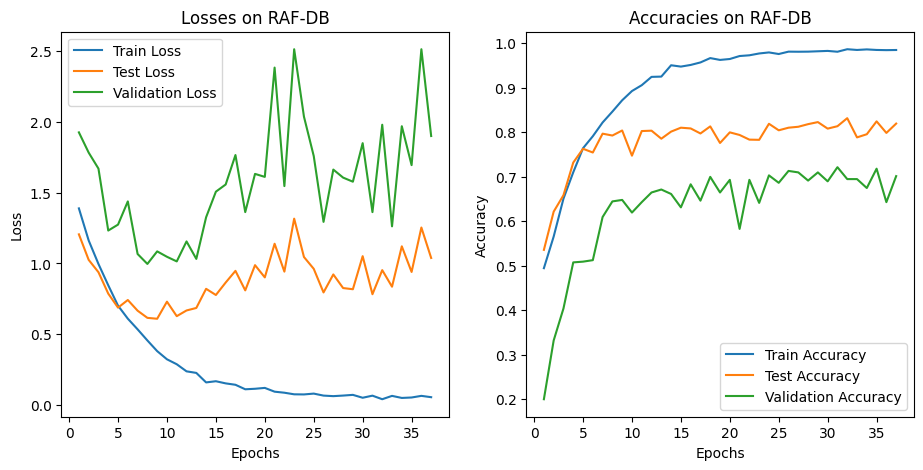

In [7]:
plt.figure(figsize=(17, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, 38), train_losses, label='Train Loss') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 38), test_losses, label='Test Loss') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 38), val_losses, label='Validation Loss') # change this number after '(1, _)' to num_epochs+1
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses on RAF-DB')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, 38), train_accuracies, label='Train Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 38), test_accuracies, label='Test Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 38), val_accuracies, label='Validation Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracies on RAF-DB')
plt.legend()

plt.show()

In [24]:
df = pd.DataFrame({
    'Epoch': range(1, 38), # change this number after '(1, _)' to num_epochs+1
    'Train Loss': train_losses,
    'Test Loss': test_losses,
    'Validation Loss': val_losses,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Validation Accuracy': val_accuracies
})
df.to_csv('result_RAF.csv', index=False)